In [ ]:
# default_exp core

# elec_consumption

Cluster analysis and statistical learning for electricity consumption profiles.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
from elec_consumption.core import *
import datetime
from loguru import logger
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import seaborn as sns

In [ ]:
#hide
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [4 * 1.61803398875, 4]
_seed = 123  # for clustering analysis
data = {}  # contain modified dataframes

In [ ]:
#hide
df = pd.read_csv('./data/raw.csv', index_col=0)
df.columns = list(range(df.shape[1]))
df.columns.name = 'household'
df.index = pd.to_datetime(df.index)
df.index.name = 'datetime'

## 1. Introduction

There are 500 time series spanning 122 days (Aug 1, 2017 to Nov 30, 2017).

Preview first five rows for first five households. Unit is presumed to be kV.

In [ ]:
#hide_input
df.iloc[:5, :5]

household,0,1,2,3,4
datetime,,,,,
2017-08-01 00:00:00,0.094,0.028,0.116,0.096,0.189
2017-08-01 00:30:00,0.039,0.050,0.068,0.077,0.156
2017-08-01 01:00:00,0.088,0.060,0.044,0.095,0.118
2017-08-01 01:30:00,0.046,0.023,0.067,0.092,0.145
2017-08-01 02:00:00,0.082,0.020,0.068,0.085,0.153


Power consumption profiles of household 0, 1, 2 on Aug 1, 2017 are plotted:

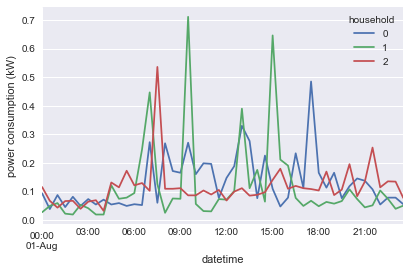

In [ ]:
#hide_input
df[df.index.date == datetime.date(2017, 8, 1)].iloc[:, :3].plot(
    ylabel='power consumption (kW)'
);

Aggregate profile of 0 hourly and compare two series:

In [ ]:
#hide
df_hour_0 = (
    df[df.index.date == datetime.date(2017, 8, 1)].loc[:, 0]
    .resample('1H', closed='left').mean().to_frame()
)
df_hour_0.columns = ['power']
df_hour_0['freq'] = 'hour'
df_hour_0.reset_index(inplace=True)
df_hour_0.set_index(['datetime', 'freq'], inplace=True)

In [ ]:
#hide
df_halfhour_0 = df[df.index.date == datetime.date(2017, 8, 1)].loc[:, 0].to_frame()
df_halfhour_0.columns = ['power']
df_halfhour_0['freq'] = 'half-hour'
df_halfhour_0.reset_index(inplace=True)
df_halfhour_0.set_index(['datetime', 'freq'], inplace=True)

In [ ]:
#hide
df_0 = pd.concat([df_hour_0, df_halfhour_0])

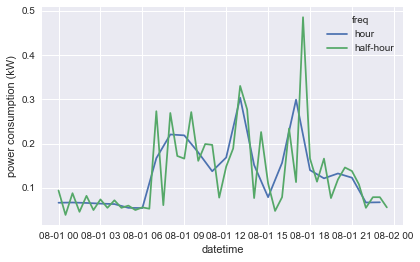

In [ ]:
#hide_input
ax = sns.lineplot(data=df_0, y='power', x='datetime', hue='freq')
ax.set(ylabel='power consumption (kW)');

Daily downsampled mean values of household 0 for the whole period:

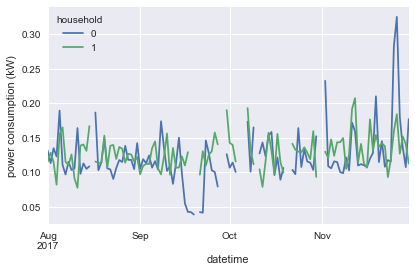

In [ ]:
#hide_input
df_daily = df.iloc[:, :2].resample('1D', closed='left').mean()
df_daily.plot(ylabel='power consumption (kW)');

## 2. Handle Missing Entries

- For households 162, 428 and 432, two entries in different sets of dates are missed".
- For all the other households, 48 entries in different sets of dates are missed.


`NaN` values can be filled with 0, but it will distort clustering.

In [ ]:
#hide
_dates_two_nan_somedays = {162, 428, 432}

In [ ]:
# There are only 186 rows having complete data.
assert df.dropna(axis=0).shape[0] == 186

In [ ]:
#hide
def filt_dates_missing(df: DataFrame, household: int) -> DataFrame:
    """Find num of missing entries for every day.

    Args:
        df: original dataframe.
        household: integer index of given household.

    Return:
        Num of NaN per day.
    """
    num_nan_daily = (
        df.iloc[:, household].groupby(df.index.date)
        .apply(lambda x: x.isna().values.sum()).to_frame()
    )
    num_nan_daily.columns = ['num_nan_daily']
    return num_nan_daily[num_nan_daily['num_nan_daily'] > 0]

In [ ]:
#hide
def filt_dates_missing_set(df: DataFrame, household: int) -> set:
    """Find missing days in series of `household`.

    Args:
        df: original dataframe.
        household: integer index of given household.

    Return:
        Dates when all entries are missing.
    """
    if household in _dates_two_nan_somedays:
        logger.warning(
            f'Household {household} misses two entries sometimes'
        )
    return set(filt_dates_missing(df, household).index)

It seems that two sets of missing days corresponding to any pair of households (except 162, 428, 432) are differentiated by 1 dates.

In [ ]:
#hide
assert filt_dates_missing_set(df, 0).symmetric_difference(
    filt_dates_missing_set(df, 1)
) == {datetime.date(2017, 9, 18)}

In [ ]:
#hide
res = {}
num_household = 5
for h in range(num_household - 1):
    for j in range(h+1, num_household):
        diff = filt_dates_missing_set(df, 0).symmetric_difference(
            filt_dates_missing_set(df, 1)
        ) 
        res[(h, j)] = list(diff)[0]

In [ ]:
#hide
df_dates = pd.DataFrame.from_dict(res, orient='index')
df_dates.index = pd.MultiIndex.from_tuples(df_dates.index)
df_dates.columns = ['difference']
df_dates.index.names = ['a_household', 'another_household']

In [ ]:
df_dates

difference
a_household another_household            
0           1                  2017-09-18
            2                  2017-09-18
            3                  2017-09-18
            4                  2017-09-18
1           2                  2017-09-18
            3                  2017-09-18
            4                  2017-09-18
2           3                  2017-09-18
            4                  2017-09-18
3           4                  2017-09-18

Linear interpolation is not very useful.

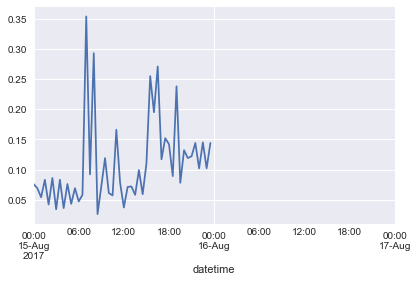

In [ ]:
#hide
df.loc[
    datetime.date(2017, 8, 15):datetime.date(2017, 8, 17), 0
].plot();

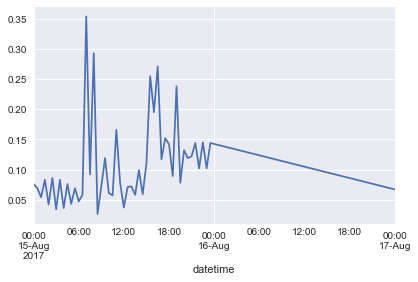

In [ ]:
#hide_input
df.loc[
    datetime.date(2017, 8, 15):datetime.date(2017, 8, 17), 0
].interpolate(method='linear').plot();

## 3. Time Series Analysis

Different statistical model can be built for different clusters of households. Forecasts with two different resolutions, hourly and daily, are expected.